In [1]:
!pip install pandas matplotlib fpdf reportlab

from fpdf import FPDF
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.units import inch
from reportlab.lib import colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font', family='NanumGothic')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 한글 깨질 때 -> 코드 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [201]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train_raw.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [5]:
test_raw.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [6]:
# 행렬 값을 확인
print(' train shape: ', train_raw.shape, '\n', 'test shape: ', test_raw.shape)

 train shape:  (1205, 12) 
 test shape:  (50, 10)


In [202]:
# train 데이터셋 칼럼명 수정하기
train = train_raw.copy()  # 복사본 저장
train.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn', 'target_ln', 'target_dn']
train.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [169]:
# test 데이터셋 칼럼명 수정하기
test = test_raw.copy()
test.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn']
test.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [203]:
# 날짜를 datetime으로 변경 후 요일 정보를 숫자로 만들기
def to_datetime(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['dow'] = pd.to_datetime(df[date]).dt.weekday + 1 # 월:1,화:2,수:3,목:4,금:5

to_datetime(train, 'date'); to_datetime(test, 'date')

In [204]:
# 년, 월, 일 구분
def date_split(df):
    #df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

date_split(train)
date_split(test)

In [11]:
train.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn,year,month,day
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2


In [12]:
test.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,year,month,day
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1205 non-null   datetime64[ns]
 1   dow        1205 non-null   int32         
 2   employees  1205 non-null   int64         
 3   dayoff     1205 non-null   int64         
 4   bustrip    1205 non-null   int64         
 5   ovtime     1205 non-null   int64         
 6   remote     1205 non-null   float64       
 7   brk        1205 non-null   object        
 8   ln         1205 non-null   object        
 9   dn         1205 non-null   object        
 10  target_ln  1205 non-null   float64       
 11  target_dn  1205 non-null   float64       
 12  year       1205 non-null   int32         
 13  month      1205 non-null   int32         
 14  day        1205 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(4), object(3)
memory usage: 122.5+ KB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       50 non-null     datetime64[ns]
 1   dow        50 non-null     int32         
 2   employees  50 non-null     int64         
 3   dayoff     50 non-null     int64         
 4   bustrip    50 non-null     int64         
 5   ovtime     50 non-null     int64         
 6   remote     50 non-null     float64       
 7   brk        50 non-null     object        
 8   ln         50 non-null     object        
 9   dn         50 non-null     object        
 10  year       50 non-null     int32         
 11  month      50 non-null     int32         
 12  day        50 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(4), object(3)
memory usage: 4.4+ KB


## 1. 간단한 시각화  
### 1-1. 히스토그램을 이용해서 예측하고 싶은 타겟값들을 시각화해보기  

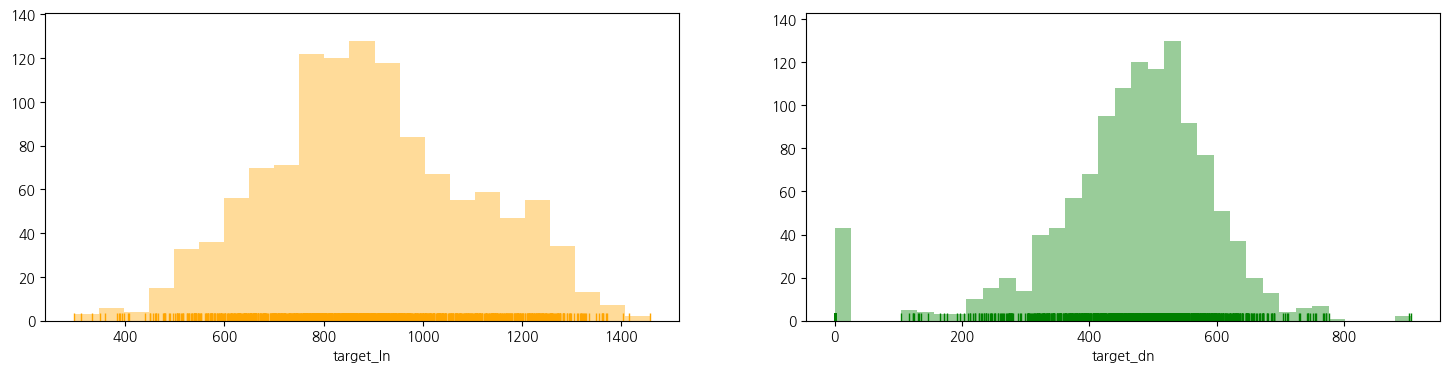

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(train["target_ln"], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(train["target_dn"], ax = ax[1], color = 'green', kde = False, rug = True)
plt.show()

## 날씨 데이터 (기온, 강수량, 풍속, 습도) 추가  

In [205]:
# 날씨 파일 불러오기
w1 = pd.read_csv('날씨1.csv', encoding='cp949')
w2 = pd.read_csv('날씨2.csv', encoding='cp949')
w3 = pd.read_csv('날씨3.csv', encoding='cp949')
w4 = pd.read_csv('날씨4.csv', encoding='cp949')
w5 = pd.read_csv('날씨5.csv', encoding='cp949')

In [206]:
# 각각 행, 열 갯수 확인
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)
print(w5.shape)

(8638, 7)
(8743, 7)
(8739, 7)
(8749, 7)
(8773, 7)


In [207]:
# 일시 컬럼을 datetime으로 변경
w1['일시'] = pd.to_datetime(w1['일시'],format='%Y-%m-%d %H:%M')
w2['일시'] = pd.to_datetime(w2['일시'],format='%Y-%m-%d %H:%M')
w3['일시'] = pd.to_datetime(w3['일시'],format='%Y-%m-%d %H:%M')
w4['일시'] = pd.to_datetime(w4['일시'],format='%Y-%m-%d %H:%M')
w5['일시'] = pd.to_datetime(w5['일시'],format='%Y-%m-%d %H:%M')

In [208]:
# 점심시간(12시)의 데이터만 추출
w1 = w1[w1['일시'].dt.hour == 12]
w2 = w2[w2['일시'].dt.hour == 12]
w3 = w3[w3['일시'].dt.hour == 12]
w4 = w4[w4['일시'].dt.hour == 12]
w5 = w5[w5['일시'].dt.hour == 12]

In [209]:
# 행, 열 갯수 다시 확인
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)
print(w5.shape)

(361, 7)
(364, 7)
(364, 7)
(365, 7)
(366, 7)


In [210]:
# 12시 날씨 데이터 concat
w_all = pd.concat([w1,w2,w3,w4,w5])
w_all.head(2)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,NaN,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,NaN,1.6,24.0


In [211]:
# NaN값 행 확인
w_all[w_all.isna( ).any(axis=1)]

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,NaN,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,NaN,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,NaN,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,NaN,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,NaN,1.0,17.0
...,...,...,...,...,...,...,...
8628,192,진주,2021-01-20 12:00:00,4.8,NaN,1.2,31.0
8652,192,진주,2021-01-21 12:00:00,9.1,NaN,0.4,52.0
8676,192,진주,2021-01-22 12:00:00,8.4,NaN,0.5,94.0
8724,192,진주,2021-01-24 12:00:00,11.1,NaN,2.4,59.0


In [212]:
# 기록 안된 강수량컬럼 -> 0으로 채움
w_all['강수량(mm)'] = w_all['강수량(mm)'].fillna(value = 0)
w_all

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,0.0,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,0.0,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,0.0,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,0.0,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,0.0,1.0,17.0
...,...,...,...,...,...,...,...
8676,192,진주,2021-01-22 12:00:00,8.4,0.0,0.5,94.0
8700,192,진주,2021-01-23 12:00:00,10.1,0.3,0.6,91.0
8724,192,진주,2021-01-24 12:00:00,11.1,0.0,2.4,59.0
8748,192,진주,2021-01-25 12:00:00,11.3,0.0,2.6,54.0


In [213]:
# NaN값 행 다시 확인 -> 풍속 컬럼 0 존재
w_all[w_all.isna( ).any(axis=1)]

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
6674,192,진주,2018-11-01 12:00:00,13.8,0.0,NaN,37.0
6794,192,진주,2018-11-06 12:00:00,17.6,0.0,NaN,52.0
1548,192,진주,2020-03-31 12:00:00,17.3,0.0,NaN,42.0
1884,192,진주,2020-04-14 12:00:00,19.6,0.0,NaN,14.0


In [214]:
# 모두 0으로 채움
w_all = w_all.fillna(0)
w_all

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,0.0,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,0.0,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,0.0,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,0.0,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,0.0,1.0,17.0
...,...,...,...,...,...,...,...
8676,192,진주,2021-01-22 12:00:00,8.4,0.0,0.5,94.0
8700,192,진주,2021-01-23 12:00:00,10.1,0.3,0.6,91.0
8724,192,진주,2021-01-24 12:00:00,11.1,0.0,2.4,59.0
8748,192,진주,2021-01-25 12:00:00,11.3,0.0,2.6,54.0


In [215]:
w_all.isna().any() # NaN값 없음

지점         False
지점명        False
일시         False
기온(°C)     False
강수량(mm)    False
풍속(m/s)    False
습도(%)      False
dtype: bool

In [216]:
w_all.isna().sum()

지점         0
지점명        0
일시         0
기온(°C)     0
강수량(mm)    0
풍속(m/s)    0
습도(%)      0
dtype: int64

In [217]:
# 필요없는 컬럼 drop
w_all = w_all.drop(['지점', '지점명'], axis = 1)

# train 데이터셋과 합치기 위해 컬럼명 수정
w_all.rename(columns = {'일시':'date'}, inplace = True)  # inplace = True -> 바뀐 부분 적용

In [185]:
# 수정한 컬럼 다시 datetime 형식으로 변경
w_all['date'] = pd.to_datetime(w_all['date'],format='%Y-%m-%d %H:%M')
w_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 8772
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1820 non-null   datetime64[ns]
 1   기온(°C)   1820 non-null   float64       
 2   강수량(mm)  1820 non-null   float64       
 3   풍속(m/s)  1820 non-null   float64       
 4   습도(%)    1820 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 85.3 KB


In [218]:
# 일자 컬럼에서 시간제외
w_all['date'] = w_all['date'].dt.date

# 시간 분리한 일자 컬럼 다시 datetime으로 변경
w_all['date'] = pd.to_datetime(w_all['date'], format = "%Y-%m-%d")

w_all.head(2)

,date,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,2016-02-01,3.0,0.0,1.9,24.0
24,2016-02-02,1.7,0.0,1.6,24.0


-  폭염 컬럼 생성  

In [219]:
# 기온컬럼 이용 -> 폭염인 경우 1 / 폭염 아닌 경우 0으로 분류

hw = 33         # 폭염 기준 온도값 초기화
w_all['폭염'] = w_all['기온(°C)'].apply(lambda x: 1 if x >= hw else 0) # 33도 이상이면 1 아니면 0
w_all.head(2)

# w_all[w_all['폭염']==1].head(2) 폭염 1인 행들 2개 출력

,date,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염
0,2016-02-01,3.0,0.0,1.9,24.0,0
24,2016-02-02,1.7,0.0,1.6,24.0,0


- 체감온도와 불쾌지수 컬럼 생성  

In [220]:
# 불쾌지수, 체감온도 계산
# 불쾌지수 = 1.8x기온 – 0.55x(1–습도)x(1.8x기온–26)+32
# 체감온도 = 13.12 + 0.6215*기온 - 11.37*풍속^0.16 + 0.3965*풍속^0.16*기온

w_all['불쾌지수'] = 1.8 * w_all['기온(°C)'] - 0.55 * (1 - w_all['습도(%)'] / 100) * (1.8 * w_all['기온(°C)'] - 26) + 32
w_all['체감온도'] = 13.12 + 0.6215 * w_all['기온(°C)']- 11.37 * w_all['풍속(m/s)']**0.16 + 0.3965 * w_all['기온(°C)'] * w_all['풍속(m/s)']**0.16

w_all.head(2)

,date,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도
0,2016-02-01,3.0,0.0,1.9,24.0,0,46.01080,3.702926
24,2016-02-02,1.7,0.0,1.6,24.0,0,44.64892,2.645242


In [221]:
# NaN값 여부
print(w_all.isna().sum())

print(w_all.info())

date       0
기온(°C)     0
강수량(mm)    0
풍속(m/s)    0
습도(%)      0
폭염         0
불쾌지수       0
체감온도       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 8772
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1820 non-null   datetime64[ns]
 1   기온(°C)   1820 non-null   float64       
 2   강수량(mm)  1820 non-null   float64       
 3   풍속(m/s)  1820 non-null   float64       
 4   습도(%)    1820 non-null   float64       
 5   폭염       1820 non-null   int64         
 6   불쾌지수     1820 non-null   float64       
 7   체감온도     1820 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 128.0 KB
None


In [197]:
# 2018-10-19 날씨 기록 없음
w_all.iloc[985:995]

,date,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도
6251,2018-10-14,19.0,0.0,0.8,46.0,0,63.76460,21.226558
6275,2018-10-15,19.8,0.0,1.6,46.0,0,64.77692,21.631541
6299,2018-10-16,16.3,0.0,1.1,64.0,0,60.67868,18.267996
6323,2018-10-17,18.9,0.0,0.9,45.0,0,63.59395,21.054995
6347,2018-10-18,17.5,0.0,2.7,29.0,0,61.35225,18.801742
6390,2018-10-20,19.2,0.0,2.1,35.0,0,63.49980,20.822030
6414,2018-10-21,18.3,0.0,1.0,40.0,0,62.64980,20.379400
6438,2018-10-22,17.8,0.0,0.8,50.0,0,62.37900,20.021646
6462,2018-10-23,17.8,0.0,1.0,55.0,0,62.54510,19.870400
6486,2018-10-24,17.7,0.0,2.1,42.0,0,61.99066,19.220066


- train 데이터셋과 병합  

In [222]:
# train+날씨 merge
train = train.merge(w_all, on = 'date', how='left').fillna(0)  # train 데이터셋을 기준으로 병합, 20181019는 0으로 채움
train.head(3)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,...,year,month,day,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,2016,2,1,3.0,0.0,1.9,24.0,0.0,46.01080,3.702926
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,2016,2,2,1.7,0.0,1.6,24.0,0.0,44.64892,2.645242
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,2016,2,3,3.2,0.0,1.5,31.0,0.0,45.44108,4.330567


In [223]:
train.isna().sum()

date         0
dow          0
employees    0
dayoff       0
bustrip      0
ovtime       0
remote       0
brk          0
ln           0
dn           0
target_ln    0
target_dn    0
year         0
month        0
day          0
기온(°C)       0
강수량(mm)      0
풍속(m/s)      0
습도(%)        0
폭염           0
불쾌지수         0
체감온도         0
dtype: int64

## 미세먼지 데이터 추가  

In [224]:
# 미세먼지 데이터셋 불러오기 (경상남도 진주시 상대동(측정소))
m1 = pd.read_csv('미세먼지_160201_170126.csv', encoding='cp949')
m2 = pd.read_csv('미세먼지_170127_180126.csv', encoding='cp949')
m3 = pd.read_csv('미세먼지_180127_190126.csv', encoding='cp949')
m4 = pd.read_csv('미세먼지_190127_200126.csv', encoding='cp949')
m5 = pd.read_csv('미세먼지_200127_210126.csv', encoding='cp949')

In [225]:
# 년도별 미세먼지 데이터 concat
m_all = pd.concat([m1, m2, m3, m4, m5])
m_all.head(3)

,일자,PM-10
0,2016-02-01,36.0
1,2016-02-02,34.0
2,2016-02-03,54.0


In [226]:
# 인덱스 초기화
m_all = m_all.reset_index(drop=True)
m_all.head(5)

,일자,PM-10
0,2016-02-01,36.0
1,2016-02-02,34.0
2,2016-02-03,54.0
3,2016-02-04,78.0
4,2016-02-05,51.0


In [227]:
# NaN 값을 월평균 미세먼지농도 값으로 대체하는 함수

def nan_to_month_mean(df, date_col, value_col):

    df[date_col] = pd.to_datetime(df[date_col]) # 일자를 datetime 형식으로 변환
    df['month'] = df[date_col].dt.month         # 'month' 열 추가

    month_means = df.groupby('month')[value_col].transform('mean') # 월별 평균값 계산
    df[value_col] = df[value_col].fillna(month_means)               # 결측값을 월평균값으로 대체

    df.drop(columns=['month'], inplace=True)    # 'month' 열 삭제

    return df

In [228]:
# NaN값에 평균값 적용
m_all = nan_to_month_mean(m_all, '일자', 'PM-10')
m_all.head()

,일자,PM-10
0,2016-02-01,36.0
1,2016-02-02,34.0
2,2016-02-03,54.0
3,2016-02-04,78.0
4,2016-02-05,51.0


In [229]:
# NaN값 여부
print(m_all.isna().any())

print(m_all.info())

일자       False
PM-10    False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      1822 non-null   datetime64[ns]
 1   PM-10   1822 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.6 KB
None


In [230]:
# train 데이터셋과 합치기 위해 컬럼명 변경
m_all.rename(columns = {'일자' : 'date',
                        'PM-10':'미세먼지'}, inplace = True)
m_all.head(2)

,date,미세먼지
0,2016-02-01,36.0
1,2016-02-02,34.0


- train 데이터셋과 병합  

In [231]:
train = train.merge(m_all, on = 'date', how='left')  # train 데이터셋을 기준으로 병합
train.head(3)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,...,month,day,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도,미세먼지
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,2,1,3.0,0.0,1.9,24.0,0.0,46.01080,3.702926,36.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,2,2,1.7,0.0,1.6,24.0,0.0,44.64892,2.645242,34.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,2,3,3.2,0.0,1.5,31.0,0.0,45.44108,4.330567,54.0


In [232]:
train.isna().sum()

date         0
dow          0
employees    0
dayoff       0
bustrip      0
ovtime       0
remote       0
brk          0
ln           0
dn           0
target_ln    0
target_dn    0
year         0
month        0
day          0
기온(°C)       0
강수량(mm)      0
풍속(m/s)      0
습도(%)        0
폭염           0
불쾌지수         0
체감온도         0
미세먼지         0
dtype: int64

## 강수형태 데이터 추가

In [233]:
# 강수형태 데이터 불러오기
r1 = pd.read_csv('충무공동_강수형태_201602_201701.csv')
r2 = pd.read_csv('충무공동_강수형태_201702_201801.csv')
r3 = pd.read_csv('충무공동_강수형태_201802_201901.csv')
r4 = pd.read_csv('충무공동_강수형태_201902_202001.csv')
r5 = pd.read_csv('충무공동_강수형태_202002_202101.csv')

# r_list 생성
r_list = [r1, r2, r3, r4, r5]

# 각 DataFrame의 열 이름을 변경
for i in r_list:
    i.columns = ['일자', '시간', '강수형태']

# 년도별 강수형태 데이터 concat
r_all = pd.concat([r1, r2, r3, r4, r5])
r_all.head()

,일자,시간,강수형태
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0


In [234]:
# 10시 ~14시(1000 ~ 1400기간)데이터만 추출
rain1 = r_all[r_all['시간'] >= 1000]  # 1000(10시)이상 데이터 추출 후 저장
rain2 = rain1[rain1['시간'] <= 1400]  # 10시 이상 데이터 중 14시 이하의 데이터 추출 후 저장
rain_use = rain2.copy()                # 복사본으로 저장
#rain_use.head(4)

# 인덱스 초기화
rain_use = rain_use.reset_index(drop=True)
rain_use.head(5)

,일자,시간,강수형태
0,1,1000.0,0.0
1,1,1100.0,0.0
2,1,1200.0,0.0
3,1,1300.0,0.0
4,1,1400.0,0.0


In [235]:
import pandas as pd
from datetime import datetime, timedelta, date

start_date = pd.to_datetime('2016-02-01')
end_date = pd.to_datetime('2021-01-26')
#n = 5 # 10, 11, 12, 13, 14 -> 다섯번 반복(같은 날짜 다섯번 반복 )

start_date

Timestamp('2016-02-01 00:00:00')

In [236]:
# 일만 표시되어 있는 일자 컬럼 -> 년-월-일로 변경
def date_list(start, end, n=1):
  d_list = []
  while start.strftime('%Y%m%d') != (end + timedelta(days=1)).strftime('%Y%m%d'):
    for i in range(n):
      d_list.append(start.strftime('%Y-%m-%d'))
    start += timedelta(days=1)

  return d_list

# 함수 적용
dlist = date_list(start_date, end_date, 5)

# 모든행, '일자'컬럼에 dlist 적용
rain_use.loc[:,'일자'] = dlist
rain_use.head()

,일자,시간,강수형태
0,2016-02-01,1000.0,0.0
1,2016-02-01,1100.0,0.0
2,2016-02-01,1200.0,0.0
3,2016-02-01,1300.0,0.0
4,2016-02-01,1400.0,0.0


- rain과 snow컬럼 추가  

In [237]:
# rain 컬럼 추가 -> 강수형태가 1 or 2이면 -> 1 / 그 외(-1 or 3)이면 -> 0
rain_use['rain'] = rain_use['강수형태'].apply(lambda x: 1 if x in [1, 2] else 0)

# snow 컬럼 추가 -> 강수형태가 3이면 -> 1 / 그 외에는 0
rain_use['snow'] = rain_use['강수형태'].apply(lambda x: 1 if x == 3 else 0)

# 중복된 날짜 제거 (첫 번째 중복된 행을 유지)
rain_use = rain_use.drop_duplicates(subset=['일자'])
rain_use.head()

,일자,시간,강수형태,rain,snow
0,2016-02-01,1000.0,0.0,0,0
5,2016-02-02,1000.0,0.0,0,0
10,2016-02-03,1000.0,0.0,0,0
15,2016-02-04,1000.0,0.0,0,0
20,2016-02-05,1000.0,0.0,0,0


In [238]:
# 병합을 위해 컬럼명 수정
rain_use.rename(columns = {'일자' : 'date'}, inplace = True)

# datetime으로 변경
rain_use['date'] = pd.to_datetime(rain_use['date'], format = "%Y-%m-%d")
rain_use.head(2)

,date,시간,강수형태,rain,snow
0,2016-02-01,1000.0,0.0,0,0
5,2016-02-02,1000.0,0.0,0,0


In [135]:
rain_use.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 0 to 9105
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1822 non-null   datetime64[ns]
 1   시간      1822 non-null   float64       
 2   강수형태    1822 non-null   float64       
 3   rain    1822 non-null   int64         
 4   snow    1822 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 149.9 KB


- train 데이터셋과 병합  

In [239]:
train = train.merge(rain_use, on = 'date', how = 'left')
train

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,...,풍속(m/s),습도(%),폭염,불쾌지수,체감온도,미세먼지,시간,강수형태,rain,snow
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,1.9,24.0,0.0,46.01080,3.702926,36.0,1000.0,0.0,0,0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,1.6,24.0,0.0,44.64892,2.645242,34.0,1000.0,0.0,0,0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,1.5,31.0,0.0,45.44108,4.330567,54.0,1000.0,0.0,0,0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,0.7,30.0,0.0,46.10590,6.065918,78.0,1000.0,0.0,0,0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,1.0,17.0,0.0,50.03229,8.163400,51.0,1000.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,3,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,1.2,31.0,0.0,47.22812,6.356172,34.0,1000.0,0.0,0,0
1201,2021-01-21,4,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,0.4,52.0,0.0,50.91968,12.072254,30.0,1000.0,1.0,1,0
1202,2021-01-22,5,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,0.5,94.0,0.0,47.47904,11.145135,32.0,1000.0,0.0,0,0
1203,2021-01-25,1,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,2.6,54.0,0.0,53.77198,12.115334,21.0,1000.0,0.0,0,0


In [240]:
# 폭염 컬럼 int로 형변환
train['폭염'] = train['폭염'].astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1205 non-null   datetime64[ns]
 1   dow        1205 non-null   int32         
 2   employees  1205 non-null   int64         
 3   dayoff     1205 non-null   int64         
 4   bustrip    1205 non-null   int64         
 5   ovtime     1205 non-null   int64         
 6   remote     1205 non-null   float64       
 7   brk        1205 non-null   object        
 8   ln         1205 non-null   object        
 9   dn         1205 non-null   object        
 10  target_ln  1205 non-null   float64       
 11  target_dn  1205 non-null   float64       
 12  year       1205 non-null   int32         
 13  month      1205 non-null   int32         
 14  day        1205 non-null   int32         
 15  기온(°C)     1205 non-null   float64       
 16  강수량(mm)    1205 non-null   float64       


In [241]:
train.isna().any()

date         False
dow          False
employees    False
dayoff       False
bustrip      False
ovtime       False
remote       False
brk          False
ln           False
dn           False
target_ln    False
target_dn    False
year         False
month        False
day          False
기온(°C)       False
강수량(mm)      False
풍속(m/s)      False
습도(%)        False
폭염           False
불쾌지수         False
체감온도         False
미세먼지         False
시간           False
강수형태         False
rain         False
snow         False
dtype: bool

In [243]:
train.columns

Index(['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote',
       'brk', 'ln', 'dn', 'target_ln', 'target_dn', 'year', 'month', 'day',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '폭염', '불쾌지수', '체감온도', '미세먼지',
       '시간', '강수형태', 'rain', 'snow'],
      dtype='object')

- feature engineering  